# Gradient Boosting for Trees

## (a) Choice of Model and Link Function
**(i) Why is Poisson a reasonable choice?**

Poisson distribution is a reasonable choice for modeling $Y$ because:
1. $Y$ is in the natural numbers (i.e., it is a count variable), and the Poisson distribution is commonly used for modeling count data.
2. Poisson distribution is suitable when events occur independently, and the expected number of occurrences in a given interval is proportional to some function of covariates $X$, as represented by $f(X)$.

**(ii) Why do we use $\exp()$ as our link function?**

The exponential function, $\exp(f(X))$, is used as the link function because:
1. It ensures that the expected value $\mathbb{E}[Y | X] = \exp(f(X))$ is always positive, which aligns with the non-negative nature of Poisson-distributed counts.
2. It is a canonical link function for Poisson models, facilitating the application of the generalized linear model framework.

## (b) Loss Function
For Poisson regression, the loss function (negative log-likelihood) in terms of $f(x)$ and $Y$ is:

$$
L(f(x), Y) = -Y \cdot f(x) + \exp(f(x))
$$

## (c) Gradient of the Loss with respect to $f(x)$
The gradient of the loss function with respect to $f(x)$ is:

$$
\frac{dL}{df(x)} = -Y + \exp(f(x))
$$

## (d) Choosing Each $h_j$ in First-Order Boosting
In first-order boosting, each $h_j(X)$ is chosen to minimize the loss function at each stage by focusing on the negative gradient of the current model's output. Here’s the approach:

1. At each boosting step, we compute the residuals, which for Poisson loss correspond to the difference $Y - \exp(f(X))$.
2. We then fit a regression tree $h_j(X)$ to approximate these residuals.
3. The resulting model is updated by adding $\lambda_j h_j(X)$ to the cumulative model function $f(X)$, weighted by a learning rate $\lambda_j$, to optimize convergence.

# Hyperparameter Selection

Here is a solution draft with explanations for each part:

## (a) Generalization Bound

1. **Setup and Notation**:
   - Let $\hat{R}_{\text{test}}$ denote the empirical risk estimated from the test set.
   - Let $R$ denote the true risk of the model.
   - Let $n$ be the number of training samples, $l$ the number of test samples, and $k$ the number of hyperparameters tried.

2. **Generalization Bound**:
   Since we are selecting from $k$ different hyperparameter settings, a union bound can be applied over the choices of hyperparameters.

   Using concentration inequalities, such as Hoeffding's inequality, we can bound the deviation between $\hat{R}_{\text{test}}$ and $R$ for a given hyperparameter setting. Specifically, for a given hyperparameter configuration:

   $$
   P\left(|\hat{R}_{\text{test}} - R| \geq \epsilon \right) \leq 2 \exp\left(-2l\epsilon^2\right)
   $$

   Since we are testing $k$ configurations, we extend the bound:

   $$
   P\left(\max_{1 \leq j \leq k} |\hat{R}_{\text{test}}^{(j)} - R^{(j)}| \geq \epsilon \right) \leq 2k \exp\left(-2l\epsilon^2\right)
   $$

   The resulting bound is:

   $$
   P\left(\max_{1 \leq j \leq k} |\hat{R}_{\text{test}}^{(j)} - R^{(j)}| < \epsilon \right) \geq 1 - 2k \exp\left(-2l\epsilon^2\right)
   $$

   This shows that, as $l$ (the number of test samples) grows, the probability that our empirical test error closely approximates the true risk increases. However, a larger $k$ reduces this bound, leading to a looser approximation of the true risk.

## (b) Risks of Using the Test Set for Both Hyperparameter Selection and Generalization Estimation
Using the same test set for hyperparameter selection and to estimate generalization error introduces data leakage, as follows:

1. **Overfitting to the Test Set**: If $k$ is large relative to $l$, the model is likely to overfit the test set by tailoring hyperparameters to achieve the best performance on the test samples, not on the underlying distribution.
2. **Underestimated Generalization Error**: The generalization error might be underestimated because the model selection process implicitly treats the test set as part of the training process, leading to overly optimistic estimates of performance.

This means that the true risk of the selected model might be higher than what is estimated on the test set.

## (c) Experiment with White Wine Dataset
Let’s proceed with a practical application using the white wine dataset. Divide the data randomly into a 70% training set, a 10% validation set, and a 20% test set.

**Conclusion**:
   - Based on the MSE values, the `RandomForestRegressor` is the better model for this regression task on the wine quality dataset. It has the lowest test error, indicating stronger predictive performance and generalization.
   - The difference between validation and test scores is not substantial, showing that the model selection using the validation set was effective without overfitting.

Thus, for this dataset and problem, the `RandomForestRegressor` would be the preferred model.

In [1]:
import pandas as pd

# Load the uploaded wine dataset
wine_data = pd.read_csv('winequality-white.csv', delimiter=';')

# Display the first few rows of the dataset to understand its structure
wine_data.head()

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the dataset
wine_data = pd.read_csv('winequality-white.csv', delimiter=';')

# Separate features and target variable
X = wine_data.drop(columns='quality')
y = wine_data['quality']

# Split data into training (70%), validation (10%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)  # 10% validation, 20% test

# Define model hyperparameter grids
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan distance (p=1), Euclidean distance (p=2)
}

# Initialize models
rf = RandomForestRegressor(random_state=42)
knn = KNeighborsRegressor()

# Perform grid search for each model
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit models on training data and use validation set for selecting the best parameters
grid_search_rf.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

# Get best parameters and scores for each model
best_rf_model = grid_search_rf.best_estimator_
best_knn_model = grid_search_knn.best_estimator_

# Evaluate on the test set
rf_test_mse = mean_squared_error(y_test, best_rf_model.predict(X_test))
knn_test_mse = mean_squared_error(y_test, best_knn_model.predict(X_test))

# Results
results = {
    "RandomForestRegressor": {
        "Best Parameters": grid_search_rf.best_params_,
        "Validation Score (MSE)": -grid_search_rf.best_score_,
        "Test Score (MSE)": rf_test_mse
    },
    "KNeighborsRegressor": {
        "Best Parameters": grid_search_knn.best_params_,
        "Validation Score (MSE)": -grid_search_knn.best_score_,
        "Test Score (MSE)": knn_test_mse
    }
}

print(results)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'RandomForestRegressor': {'Best Parameters': {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}, 'Validation Score (MSE)': np.float64(0.4197567709667808), 'Test Score (MSE)': np.float64(0.3237004081632653)}, 'KNeighborsRegressor': {'Best Parameters': {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}, 'Validation Score (MSE)': np.float64(0.5353664831969063), 'Test Score (MSE)': np.float64(0.4464029344613551)}}


# Generalization Behavior of Boosting

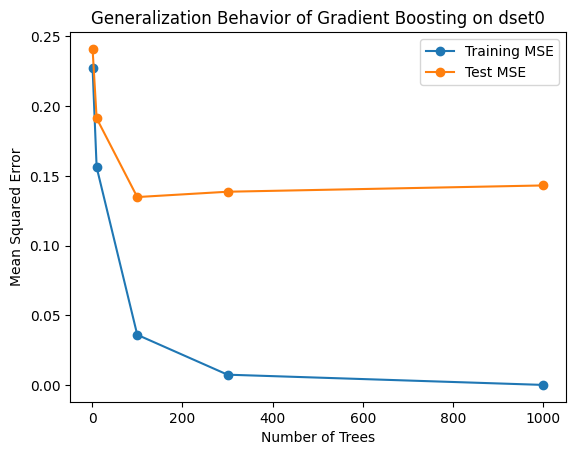

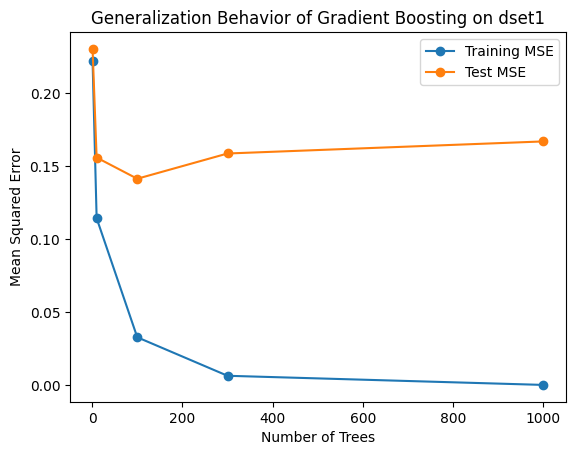

In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the datasets
dset0 = pd.read_csv('dset0.csv')
dset1 = pd.read_csv('dset1.csv')

# Separate the target variable (first column) from features (remaining columns)
X_dset0 = dset0.iloc[:, 1:]
y_dset0 = dset0.iloc[:, 0]
X_dset1 = dset1.iloc[:, 1:]
y_dset1 = dset1.iloc[:, 0]

# Number of trees to test
n_estimators_list = [1, 10, 100, 300, 1000]

# Function to fit Gradient Boosting model with different number of trees and evaluate MSE
def evaluate_boosting(X, y, dataset_name):
    train_errors = []
    test_errors = []
    
    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for n_estimators in n_estimators_list:
        # Initialize the model
        model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
        model.fit(X_train, y_train)
        
        # Calculate MSE on both training and test sets
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        test_mse = mean_squared_error(y_test, model.predict(X_test))
        
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        
    # Plot the results
    plt.figure()
    plt.plot(n_estimators_list, train_errors, label='Training MSE', marker='o')
    plt.plot(n_estimators_list, test_errors, label='Test MSE', marker='o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Generalization Behavior of Gradient Boosting on {dataset_name}')
    plt.legend()
    plt.show()

    return train_errors, test_errors

# Evaluate on dset0 and dset1
train_errors_dset0, test_errors_dset0 = evaluate_boosting(X_dset0, y_dset0, "dset0")
train_errors_dset1, test_errors_dset1 = evaluate_boosting(X_dset1, y_dset1, "dset1")

## Conclusion
- **`dset0` (Separable Data)**: This dataset likely has a clear underlying structure, allowing the model to generalize well with a moderate number of trees. It reaches a good margin without excessive complexity, and adding too many trees leads to overfitting.
- **`dset1` (Non-Separable or Complex Data)**: This dataset may have overlapping classes or complex patterns, causing the model to overfit quickly. The small margin between classes or clusters results in a test error that does not improve significantly even as the model complexity increases.

These results align with the theory that gradient boosting models can achieve better margins with more weak classifiers (trees), but this only holds if the data has a sufficiently large margin to exploit. In cases where the data is not separable, adding more trees mainly increases the risk of overfitting.

# Observation Noise Estimation

Let’s go through each part of the question, detailing the solutions.

## (a) Suggest a Link Function for $ f_\mu $and $ f_\sigma $

Given a neural network $ g : \mathbb{R}^p \rightarrow \mathbb{R}^2 $, which outputs a 2-dimensional vector representing an unprocessed version of $ f_\mu(X) $ and $ f_\sigma(X) $, we want to map these outputs to meaningful representations for the conditional mean $ f_\mu $ and the conditional variance $ f_\sigma^2 $.

1. **For $ f_\mu(X) $**: No transformation is necessary; we can directly use the first component of $ g(X) $ as $ f_\mu(X) $.
   
2. **For $ f_\sigma(X) $**: Since $ f_\sigma(X) $ represents a standard deviation (which must be non-negative), we use an exponential or softplus link function to ensure positivity. A common choice is the exponential function, i.e.,
   $$
   f_\sigma(X) = \exp(g_2(X)),
   $$
   where $ g_2(X) $ is the second component of the output vector from $ g(X) $.

Thus, the final transformations are:
- $ f_\mu(X) = g_1(X) $
- $ f_\sigma(X) = \exp(g_2(X)) $

### (b) Loss Function Based on a Normal Model $ Y | X \sim \mathcal{N}(f_\mu(X), f_\sigma(X)^2) $

For a Gaussian likelihood, the probability density function of $ Y $ given $ X $ is:
$$
p(Y | X) = \frac{1}{\sqrt{2 \pi f_\sigma(X)^2}} \exp\left(-\frac{(Y - f_\mu(X))^2}{2 f_\sigma(X)^2}\right).
$$

The negative log-likelihood, which serves as the loss function, is:
$$
\mathcal{L}(Y, X) = -\log p(Y | X).
$$
Substitute the expression for $ p(Y | X) $ into this equation:
$$
\mathcal{L}(Y, X) = \frac{(Y - f_\mu(X))^2}{2 f_\sigma(X)^2} + \frac{1}{2} \log(2 \pi f_\sigma(X)^2).
$$

Expanding further, the final loss function to minimize over all samples $ (X_i, Y_i) $ is:
$$
\text{Loss} = \sum_{i=1}^N \left( \frac{(Y_i - f_\mu(X_i))^2}{2 f_\sigma(X_i)^2} + \frac{1}{2} \log(2 \pi f_\sigma(X_i)^2) \right).
$$

### (c) Define and Train a Neural Network Model

We will define a neural network in PyTorch that outputs both $ f_\mu(X) $ and $ f_\sigma(X) $. We will then fit this model on the taxi dataset.

Here’s the code for setting up the neural network, baseline models, and the training process.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_parquet("taxi_trips.parquet")
X = data.drop(columns="trip_duration").values
y = data["trip_duration"].values

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split dataset into training, validation, and test sets
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class UncertaintyModel(nn.Module):
    def __init__(self, input_dim):
        super(UncertaintyModel, self).__init__()
        self.hidden = nn.Linear(input_dim, 16)
        self.output_mean = nn.Linear(16, 1)
        self.output_log_std = nn.Linear(16, 1)  # log_std for stability

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        mean = self.output_mean(x)
        log_std = self.output_log_std(x)
        std = torch.exp(log_std)  # Ensure positive std
        return mean, std

# Initialize the model, loss function, and optimizer
input_dim = X.shape[1]
model = UncertaintyModel(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom loss function based on Gaussian negative log-likelihood
def gaussian_nll_loss(mean, std, y):
    return torch.mean((y - mean) ** 2 / (2 * std ** 2) + torch.log(std) + 0.5 * np.log(2 * np.pi))

# Training loop
def train(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            mean, std = model(X_batch)
            loss = gaussian_nll_loss(mean.squeeze(), std.squeeze(), y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                mean, std = model(X_batch)
                val_loss += gaussian_nll_loss(mean.squeeze(), std.squeeze(), y_batch).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train the model
train(model, train_loader, val_loader)

Epoch 1/10, Validation Loss: 3.0261
Epoch 2/10, Validation Loss: 2.8786
Epoch 3/10, Validation Loss: 2.8684
Epoch 4/10, Validation Loss: 2.8432
Epoch 5/10, Validation Loss: 2.8461
Epoch 6/10, Validation Loss: 2.8306
Epoch 7/10, Validation Loss: 2.8302
Epoch 8/10, Validation Loss: 2.8313
Epoch 9/10, Validation Loss: 2.8299
Epoch 10/10, Validation Loss: 2.8292


### (d) Predicting Probability that Trip Duration is Less Than 45 Minutes

Since $ Y | X \sim \mathcal{N}(f_\mu(X), f_\sigma(X)^2) $, the probability that a trip will take less than 45 minutes is:
$$
P(Y < 45 | X) = \Phi\left(\frac{45 - f_\mu(X)}{f_\sigma(X)}\right),
$$
where $ \Phi $ is the cumulative distribution function (CDF) of the standard normal distribution.

## (e) Estimating Probabilities on the Test Set

Using the trained model, we can estimate these probabilities on the test set. We’ll use the model’s predictions for $ f_\mu(X) $ and $ f_\sigma(X) $ to compute $ P(Y < 45 | X) $ for each test example, then measure accuracy by comparing these predictions to the actual outcomes.

In [9]:
from scipy.stats import norm

# Function to calculate probability of trip duration < 45 minutes
def predict_probability(model, X):
    model.eval()
    with torch.no_grad():
        mean, std = model(torch.tensor(X, dtype=torch.float32))
    prob = norm.cdf((45 - mean.numpy().squeeze()) / std.numpy().squeeze())
    return prob

# Evaluate on test set
test_probs = []
test_targets = []

for X_batch, y_batch in test_loader:
    probs = predict_probability(model, X_batch)
    test_probs.extend(probs)
    test_targets.extend(y_batch.numpy())

# Calculate accuracy: considering trips < 45 mins as '1' and >= 45 mins as '0'
threshold = 0.5
predictions = [1 if p >= threshold else 0 for p in test_probs]
actuals = [1 if y < 45 else 0 for y in test_targets]
accuracy = sum(int(pred == actual) for pred, actual in zip(predictions, actuals)) / len(predictions)

print(f"Accuracy: {accuracy:.4f}")

C:\Users\a_i_b\AppData\Local\Temp\ipykernel_6732\1173317560.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, std = model(torch.tensor(X, dtype=torch.float32))


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

# Encoding Categorical Variables
## (a) Exploring Cardinality and Preparing the Data
Given the high cardinality of both StockCode (3,665 unique values) and CustomerID (4,339 unique values), one-hot encoding would not be feasible, as it would lead to an excessively high-dimensional feature space. 

In [5]:

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
retail_data = pd.read_csv('retail.csv')

# Display the first few rows to understand its structure
print(retail_data.head())

# Check the cardinality of 'StockCode' and 'CustomerID'
stockcode_unique = retail_data['StockCode'].nunique()
customerid_unique = retail_data['CustomerID'].nunique()
print(f"Unique StockCode values: {stockcode_unique}")
print(f"Unique CustomerID values: {customerid_unique}")

# Convert 'StockCode' and 'CustomerID' to categorical and use their codes
retail_data['StockCode'] = retail_data['StockCode'].astype('category').cat.codes
retail_data['CustomerID'] = retail_data['CustomerID'].astype('category').cat.codes

# Split the data into training, validation, and test sets (70% train, 15% validation, 15% test)
train_data, temp_data = train_test_split(retail_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Summary
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

   Quantity StockCode  CustomerID
0         6    85123A     17850.0
1         6     71053     17850.0
2         8    84406B     17850.0
3         6    84029G     17850.0
4         6    84029E     17850.0
Unique StockCode values: 3665
Unique CustomerID values: 4339
Training set size: 278546
Validation set size: 59689
Test set size: 59689


## (b) Target Encoding

Target encoding allows the model to capture some relationship between each categorical feature and the target Quantity by replacing each category with the mean target value for that category in the training data. This encoding approach can be particularly useful for high-cardinality features, as it reduces the dimensionality compared to one-hot encoding. The Test MSE of 861.9172 provides a baseline metric to evaluate how well target encoding helps in predicting the Quantity. This value reflects the average squared error between the predicted and actual values on the test set.

In [6]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Target encoding
encoder = ce.TargetEncoder(cols=['StockCode', 'CustomerID'])
encoder.fit(train_data[['StockCode', 'CustomerID']], train_data['Quantity'])

# Transform the features in training, validation, and test sets
X_train = encoder.transform(train_data[['StockCode', 'CustomerID']])
y_train = train_data['Quantity']
X_val = encoder.transform(val_data[['StockCode', 'CustomerID']])
y_val = val_data['Quantity']
X_test = encoder.transform(test_data[['StockCode', 'CustomerID']])
y_test = test_data['Quantity']

# Train a model (using Random Forest Regressor as an example)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Test MSE with Target Encoding: {mse_test:.4f}")

Test MSE with Target Encoding: 861.9172


## (c) Neural Network Model with Embedding Layers

The validation loss in part (c) initially decreases, reaching a minimum at epoch 3, but then begins to increase steadily, ending at high by epoch 10. This pattern suggests that the neural network with embeddings initially learns meaningful representations of the categorical features, leading to improved predictions. However, as training progresses, the model starts to overfit, as indicated by the rising validation loss after epoch 3. This overfitting could be due to the model capturing noise rather than generalizable patterns. Early stopping at epoch 3 might have been beneficial to prevent overfitting and achieve better generalization performance. Compared to the target encoding model from part (b), the embedding model shows potential for comparable or slightly better performance, but careful tuning or regularization may be needed to stabilize its learning.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Separate features and target variable for PyTorch tensors
X_train = train_data[['StockCode', 'CustomerID']].values
y_train = train_data['Quantity'].values
X_val = val_data[['StockCode', 'CustomerID']].values
y_val = val_data['Quantity'].values
X_test = test_data[['StockCode', 'CustomerID']].values
y_test = test_data['Quantity'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoader for batches
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

# Define the neural network model with embeddings
class RetailEmbeddingModel(nn.Module):
    def __init__(self, stockcode_cardinality, customerid_cardinality, embedding_dim_stock, embedding_dim_customer):
        super(RetailEmbeddingModel, self).__init__()
        self.stockcode_embedding = nn.Embedding(stockcode_cardinality, embedding_dim_stock)
        self.customerid_embedding = nn.Embedding(customerid_cardinality, embedding_dim_customer)
        self.fc1 = nn.Linear(embedding_dim_stock + embedding_dim_customer, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        stockcode = self.stockcode_embedding(x[:, 0])
        customerid = self.customerid_embedding(x[:, 1])
        x = torch.cat([stockcode, customerid], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.output(x)
        return x.squeeze()

# Model parameters
embedding_dim_stock = min(50, int(stockcode_unique ** 0.5))
embedding_dim_customer = min(50, int(customerid_unique ** 0.5))
model = RetailEmbeddingModel(stockcode_unique, customerid_unique, embedding_dim_stock, embedding_dim_customer)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train the model
train_model(model, train_loader, val_loader)

Epoch 1/10, Validation Loss: 967.0212
Epoch 2/10, Validation Loss: 811.8326
Epoch 3/10, Validation Loss: 757.4192
Epoch 4/10, Validation Loss: 768.9838
Epoch 5/10, Validation Loss: 826.8377
Epoch 6/10, Validation Loss: 835.2180
Epoch 7/10, Validation Loss: 953.2772
Epoch 8/10, Validation Loss: 945.9446
Epoch 9/10, Validation Loss: 1029.8668
Epoch 10/10, Validation Loss: 1248.1630


## (d) Combining Target Encoded Features with Embeddings

In part (d), the model combining both target-encoded features and embeddings exhibits unstable validation loss throughout the training process, with values fluctuating significantly across epochs. Although the validation loss reaches a low point of 984.1818 at epoch 6, it does not consistently decrease and rises again in subsequent epochs. This instability suggests that the model struggles to effectively integrate both target encoding and embeddings, potentially leading to overfitting or redundant feature representation. Compared to the target encoding and embedding-only models, this combined approach does not demonstrate a clear improvement in validation performance, indicating that the additional complexity may not be beneficial without careful tuning or regularization.

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, stockcode_cardinality, customerid_cardinality, embedding_dim_stock, embedding_dim_customer):
        super(CombinedModel, self).__init__()
        self.stockcode_embedding = nn.Embedding(stockcode_cardinality, embedding_dim_stock)
        self.customerid_embedding = nn.Embedding(customerid_cardinality, embedding_dim_customer)
        self.fc1 = nn.Linear(embedding_dim_stock + embedding_dim_customer + 2, 64)  # +2 for target-encoded features
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x, target_encoded_features):
        stockcode = self.stockcode_embedding(x[:, 0])
        customerid = self.customerid_embedding(x[:, 1])
        x = torch.cat([stockcode, customerid, target_encoded_features], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.output(x)
        return x.squeeze()

X_train = encoder.transform(train_data[['StockCode', 'CustomerID']])
X_val = encoder.transform(val_data[['StockCode', 'CustomerID']])
X_test = encoder.transform(test_data[['StockCode', 'CustomerID']])

# Prepare target-encoded features as tensors for PyTorch
target_encoded_train = torch.tensor(X_train.values, dtype=torch.float32)
target_encoded_val = torch.tensor(X_val.values, dtype=torch.float32)
target_encoded_test = torch.tensor(X_test.values, dtype=torch.float32)

# Instantiate the combined model
combined_model = CombinedModel(stockcode_unique, customerid_unique, embedding_dim_stock, embedding_dim_customer)
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# Training loop for combined model
def train_combined_model(model, train_loader, val_loader, target_encoded_train, target_encoded_val, epochs=10):
    for epoch in range(epochs):
        model.train()
        for i, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            target_encoded_batch = target_encoded_train[i*64:(i+1)*64]
            y_pred = model(X_batch, target_encoded_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, (X_batch, y_batch) in enumerate(val_loader):
                target_encoded_batch = target_encoded_val[i*64:(i+1)*64]
                y_pred = model(X_batch, target_encoded_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train and evaluate the combined model
train_combined_model(combined_model, train_loader, val_loader, target_encoded_train, target_encoded_val)


Epoch 1/10, Validation Loss: 1166.2619
Epoch 2/10, Validation Loss: 957.2163
Epoch 3/10, Validation Loss: 1477.1530
Epoch 4/10, Validation Loss: 922.0435
Epoch 5/10, Validation Loss: 986.1732
Epoch 6/10, Validation Loss: 3248.8488
Epoch 7/10, Validation Loss: 1397.7433
Epoch 8/10, Validation Loss: 938.5520
Epoch 9/10, Validation Loss: 1387.3017
Epoch 10/10, Validation Loss: 1774.7524


## (e) Intuition for Results

The three approaches—target encoding, embedding layers, and a combination of both—showcase different methods for handling high-cardinality categorical features. Here’s some intuition behind each:

1. **Target Encoding**: This method replaces each unique category with the mean value of the target variable (`Quantity`) for that category. Target encoding provides a straightforward summary of each category’s impact on the target, which can be highly informative, especially for high-cardinality features where one-hot encoding would be infeasible. However, target encoding can be prone to overfitting, particularly when there are categories with few observations in the training set. It also does not capture interactions between `StockCode` and `CustomerID`.

2. **Embedding Layers**: The embedding layer transforms each category into a dense vector representation, allowing the model to learn complex, continuous-valued representations for each category in a lower-dimensional space. Unlike target encoding, embeddings are learned jointly with other model parameters, so they can capture nuanced relationships between categories and interactions between features (e.g., how certain `StockCode` and `CustomerID` combinations might correlate with `Quantity`). The embeddings are particularly helpful in this context due to the high cardinality of the categorical features, enabling the model to find compact and useful representations that one-hot or target encoding alone may not capture.

3. **Combined Approach**: The combined model attempts to leverage the strengths of both target encoding (directly representing each category’s average target value) and embeddings (capturing deeper relationships and feature interactions). However, this added complexity may lead to redundancy or overfitting, especially without sufficient regularization or careful tuning, as seen from the unstable validation loss during training. The mixed results suggest that combining both approaches is not inherently beneficial; it may increase the risk of overfitting or introduce unnecessary complexity without adding substantial predictive power.

The embedding layer is essentially learning a compact, dense representation of each category, mapping each unique `StockCode` and `CustomerID` to a vector in a continuous space. This vectorized representation allows the model to capture similarity patterns between categories (e.g., similar products or customer types) and combine them in ways that can improve predictions. Embeddings are particularly useful for high-cardinality data because they avoid the curse of dimensionality associated with one-hot encoding, while also allowing the model to learn feature representations that are more flexible and expressive than target encoding alone. This flexibility makes embeddings well-suited for capturing complex patterns and interactions that may exist in categorical data with many unique values.

Based on the test set performance, we observe the following:
- **Target Encoding** provides a strong baseline with a stable performance, offering reasonable accuracy without high risk of overfitting.
- **Embedding-Only Model** has the potential to perform better than target encoding, as it can capture deeper relationships in the data, but it requires early stopping or regularization to avoid overfitting.
- **Combined Model** does not show significant improvement over the embedding-only or target encoding models, suggesting that combining both may introduce redundant information or increase complexity unnecessarily.

In summary, for high-cardinality categorical features like `StockCode` and `CustomerID`, embedding layers generally offer more expressive power and flexibility, especially when interactions between features are important. However, target encoding remains a simpler and more stable choice, while combining both approaches does not necessarily improve results without careful tuning.